Experiment for the paper "Features for discourse-new referent detection in Russian
==============================================
Replication of CICLing-2016 paper (Toldova and Ionov 2016)
-------------------------------------

To reproduce this experiment you will need:
1. [RuCor corpus (from 2015-10-29)](http://rucoref.maimbava.net/files/rucoref_29.10.2015.zip)
2. [`scikit-learn`](http://scikit-learn.org/stable/install.html), [`unbalanced-dataset`](https://github.com/fmfn/UnbalancedDataset), [`matplotlib`](http://matplotlib.org/users/installing.html) Python modules
2. `anaphoralib` [Python module](https://github.com/max-ionov/rucoref)

Since `anaphoralib` is in an early stage of development, there is no way to install it yet, so in order to import it, you should `cd` to the folder with the module. Paths to the corpus should be updated accordingly.

In [1]:
%cd '/media/max/Extension/Projects/Coreference/'

/media/max/Extension/Projects/Coreference


In [2]:
from anaphoralib.corpora import rueval
from anaphoralib.tagsets import multeast
from anaphoralib.experiments.base import BaseClassifier
from anaphoralib import utils

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from unbalanced_dataset import SMOTE

import numpy as np

%matplotlib inline

In [3]:
lists_dir = 'CICLing-2016/wordlists'
texts_dir = 'Corpus-2015/Tokens.txt'
gs_dir = 'Corpus-2015/Groups.txt'

tagset = multeast

random_state = 42

Reading the texts from GS and matching them to actual texts
--------------

### Loading chains and GS

In [4]:
rucoref = rueval.RuCorefCorpus(multeast, rueval)

In [5]:
rucoref.load_texts(texts_dir)
rucoref.load_gs(gs_dir)

In [6]:
rucoref.find_groups()

In [7]:
rucoref.groups[0][:10]

[Во(Sp-a, 0),
 время своих прогулок(Ncnsan, 3),
 в(Sp-l, 24),
 окрестностях Симеиза(Ncfpln, 26),
 я(P-1-snn, 47),
 обратил(Vmis-sma-p, 49),
 внимание(Ncnsan, 57),
 на(Sp-a, 66),
 одинокую дачу(Ncfsan, 69),
 стоявшую(Vmps-sfa-ea, 84)]

In [8]:
rucoref.print_stats()

Number of texts: 181
Number of GS texts: 181
Number of chains in a corpus: 3638
Number of words in all chains: 16557


In [9]:
rucoref.create_indices()

### Loading special lists
Special lists load from the directory stored in `lists_dir`

In [10]:
import codecs

def load_list(filename):
    data = set()
    with codecs.open(filename, encoding='utf-8') as inp_file:
        for line in inp_file:
            data.add(line.strip('\r\n'))
    
    return data

In [11]:
import os

wordlists = {}

for filename in os.listdir(lists_dir):
    wordlists[filename.replace('.txt', '')] = load_list(os.path.join(lists_dir, filename))

In [12]:
print wordlists.keys()

['refer_to_CommKnowl', 'adj-top50', 'role_assess', 'NewRef', 'non-identity_sim', 'possessives', 'subjectivity', 'class', 'demonstratives', 'indef']


### Building indices and dictionaries

Building additional indices (of all words and all groups):

In [13]:
import collections

word_index = []
group_index = []

for i, text in enumerate(rucoref.texts):
    word_index.append(collections.defaultdict(set))
    group_index.append(collections.defaultdict(set))
    
    for word in text:
        word_index[-1]['_'.join(word.lemma)].add(word.offset)
    for group in rucoref.groups[i]:
        for g in group.iter_groups():
            group_index[-1]['_'.join(g.lemma)].add(g.offset)

In [14]:
print '\n'.join(group_index[0].keys()[:15])

спокойно
кой
другой_сторона_можжевелового_куст
линия
поднять
прежде
кругом
подставить
хотя
и
хоть
случиться
вышележащие
поддерживать
небольшой


Building sets of adjectives and pronouns for feature selection:

In [15]:
adjectives = set()
for text in rucoref.texts:
    for word in text:
        if tagset.pos_filters['adj'](word) and (len(word.tag) < 7 or word.tag[6] == 'f'):
            adjectives.add('_'.join(word.lemma))

adjectives = list(adjectives)

In [16]:
pronouns = set()
for text in rucoref.texts:
    for word in text:
        if tagset.pos_filters['pronoun'](word):
            pronouns.add('_'.join(word.lemma))

pronouns = list(pronouns)

### Creating a classifier

In [17]:
import re

class FirstMentionClassifier(BaseClassifier):
    def __init__(self):
        super(FirstMentionClassifier, self).__init__()
        
        self.feat_zones_ = ('struct', 'string', 'lists')
        self.stats = {'str_matches_before', 'head_matches_before', 'n_adj', 'len_np'}
        
        self.rx_lat = re.compile('[A-Za-z]')
        self.pronouns = {u"его", u"ее", u"её", u"ей", u"ему", u"ею", u"им", u"ими", u"их", u"которая", 
                u"которого", u"которое", u"которой", u"котором", u"которому", u"которую", u"которые", 
                u"который", u"которым", u"которыми", u"которых", u"него", u"нее", u"неё", u"ней", u"нем", 
                u"нём", u"нему", u"нею", u"ним", u"ними", u"них", u"он", u"она", u"они", u"оно", u"свое", 
                u"своё", u"своего", u"своей", u"своем", u"своём", u"своему", u"своею", u"свой", u"свои", 
                u"своим", u"своими", u"своих", u"свою", u"своя", u"себе", u"себя", u"собой", u"собою"}
        
        self.clear_stats()
        
    def get_feature_vector(self, corpus, group, i_text, save_feature_names=False):
        if save_feature_names:
            self.feature_names_ = []
            
        vctr = []
        
        group_lemma = '_'.join(group.lemma)
        group_occurrences = group_index[i_text][group_lemma] if group_lemma in group_index[i_text] else []

        head_index = group.head
        head_lemma = group.lemma[group.head]
        head_occurrences = word_index[i_text][head_lemma] if head_lemma in word_index[i_text] else []
        head_offset = group.head_offset

        group_words = group.words if group.type != 'word' else [group]

        str_matches_before = sum(1 for occ in group_occurrences if occ < group.offset)
        head_matches_before = sum(1 for occ in head_occurrences if occ < group.offset)
        
        adj_in_group = [word for word in group_words[:head_index+1] if tagset.pos_filters['adj'](word)]
        
        self.stats['str_matches_before'].append(str_matches_before)
        self.stats['head_matches_before'].append(head_matches_before)
        
        self.stats['n_adj'].append(len(adj_in_group))
        self.stats['len_np'].append(len(group_words))
        
        if 'string' in self.feat_zones_:
            vctr.append(('str_match_before=0', str_matches_before == 0))
            vctr.append(('str_match_before<2', str_matches_before < 2))
            vctr.append(('str_match_before<3', str_matches_before < 3))
            vctr.append(('str_match_before>2', str_matches_before > 2))

            vctr.append(('head_match_before=0', head_matches_before == 0))
            vctr.append(('head_match_before<2', head_matches_before < 2))
            vctr.append(('head_match_before<3', head_matches_before < 3))
            vctr.append(('head_match_before>2', head_matches_before > 2))
            
            vctr.append(('uppercase', all(word.isupper() and len(word) > 1 for word in group.wordform)))
            #vctr.append(('capitalized', any(word[0].isupper() and len(group.wordform) > 1 for word in group.wordform[1:])))
            vctr.append(('latin', any(self.rx_lat.search(word) for word in group.wordform)))
            vctr.append(('is_proper_noun', corpus.tagset.pos_filters['properNoun'](group)))
        #vctr.append(('is_pronoun', group.lemma[0] in pronouns))
        vctr.append(('is_pronoun', group.wordform[0] in self.pronouns))
        #vctr.append(('is_pronoun', multeast.pos_filters['pronoun'](group) or group.wordform[0] in pronouns))
        self.n_pronouns += 1
        
        if 'struct' in self.feat_zones_:
            i_word = corpus.words_index[i_text][group.offset]
            left_word = corpus.texts[i_text][i_word - 1] if i_word > 0 else None
            right_word = corpus.texts[i_text][i_word + len(group.wordform) + 1] \
                                if i_word + len(group.wordform) + 1 < len(corpus.texts[i_text]) else None
            vctr.append(('conj', bool((left_word and corpus.tagset.pos_filters['conj'](left_word)) 
                        or (right_word and corpus.tagset.pos_filters['conj'](right_word)))))
            
            vctr.append(('len_np<2', len(group.tags) < 2))
            vctr.append(('len_np>2', len(group.tags) > 2))
            
            vctr.append(('n_adj=0', len(adj_in_group) == 0))
            vctr.append(('n_adj>1', len(adj_in_group) > 1))
            vctr.append(('n_adj>2', len(adj_in_group) > 2))
            
        if 'lists' in self.feat_zones_:
            for l in wordlists:
                vctr.append(('in_list_{}'.format(l), any(lemma in wordlists[l] for lemma in group.lemma[:head_index+1])))
        
        if save_feature_names:
            self.feature_names_ = [feat[0] for feat in vctr]
        
        return [feat[1] for feat in vctr]
    
    def prepare_data(self, corpus, random_state=42, test_size=0.3, feature_zones=None):
        if feature_zones:
            self.feat_zones_ = feature_zones
        
        self.n_pronouns = 0
        
        self.stats['class'] = []
        
        self.groups = []
        self.x_data = []
        self.y_data = []

        self.cur_data_ = 'Binary, filtered singletons'
        self.class_names_ = ('non-first', 'first')
        
        save_features = True
    
        for i_text, text in enumerate(corpus.texts):
            for i, mention in enumerate(corpus.mentions[i_text]):
                if i not in rucoref.gs_index[i_text]:
                    continue
                    
                cur_gs_group_id = corpus.gs_index[i_text][i]
                cur_chain = corpus.gs[i_text]['chains'][corpus.chains_index[i_text][cur_gs_group_id]]

                self.y_data.append(self.class_names_.index('first') if cur_gs_group_id == cur_chain[0] 
                                   else self.class_names_.index('non-first'))

                group = corpus.heads_index[i_text][mention.offset]
                self.x_data.append(self.get_feature_vector(corpus, group, i_text, save_features))
                self.groups.append(group)
                self.stats['class'].append(self.class_names_[self.y_data[-1]])
                save_features = False

                pronoun_index = self.feature_names_.index('is_pronoun')
                if self.x_data[-1][pronoun_index]:
                    self.x_data.pop()
                    self.y_data.pop()
                    self.groups.pop()
                    for key in self.stats:
                        self.stats[key].pop()
                    continue
                
                del self.x_data[-1][pronoun_index]
                
        super(FirstMentionClassifier, self).prepare_data(corpus, random_state, test_size)
    
        del self.feature_names_[pronoun_index]
        class_numbers = [sum(1 for item in self.y_data if item == cur_class) for cur_class in range(len(self.class_names_))]
        #self.ratio = float(max(class_numbers) / float(min(class_numbers)))
        self.ratio = 3.626 # to replicate the paper (also, the results are better)

### Training and testing

In [18]:
first_mention_clf = FirstMentionClassifier()
first_mention_clf.prepare_data(rucoref, random_state=random_state, test_size=0.3)

#### Baseline

In [19]:
def baseline_predict(data):
    y_pred = np.zeros(len(data))
    for i, row in enumerate(data):
        y_pred[i] = row[0] == 1
    
    return y_pred

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


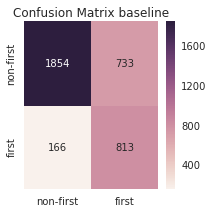

Report baseline:              precision    recall  f1-score   support

  non-first      0.918     0.717     0.805      2587
      first      0.526     0.830     0.644       979

avg / total      0.810     0.748     0.761      3566



In [20]:
first_mention_clf.test(y_pred=baseline_predict(first_mention_clf.x_data_test), test_name='baseline')

#### String features

In [21]:
first_mention_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string',))

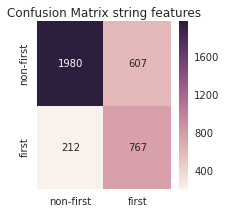

Report string features:              precision    recall  f1-score   support

  non-first      0.903     0.765     0.829      2587
      first      0.558     0.783     0.652       979

avg / total      0.809     0.770     0.780      3566



In [22]:
clf = RandomForestClassifier(n_estimators=500, random_state=random_state)
sampler = SMOTE(ratio=first_mention_clf.ratio, verbose=False, kind='borderline1', random_state=random_state)

first_mention_clf.fit(clf, sampler)
first_mention_clf.test(test_name='string features')

In [23]:
first_mention_clf.print_stats()

Classifier <class 'sklearn.ensemble.forest.RandomForestClassifier'>: fitted
Data: Binary, filtered singletons (non-first, first)
Total:	11886 samples
	8535 non-first
	3351 first


#### String + Struct features

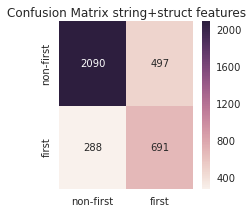

Report string+struct features:              precision    recall  f1-score   support

  non-first      0.879     0.808     0.842      2587
      first      0.582     0.706     0.638       979

avg / total      0.797     0.780     0.786      3566



In [24]:
first_mention_clf = FirstMentionClassifier()
first_mention_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct'))
clf = RandomForestClassifier(n_estimators=500, random_state=random_state)
sampler = SMOTE(ratio=first_mention_clf.ratio, verbose=False, kind='borderline1', random_state=random_state)

first_mention_clf.fit(clf, sampler)
first_mention_clf.test(test_name='string+struct features')

#### All features

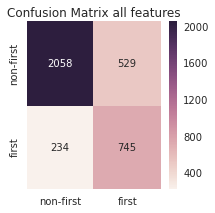

Report all features:              precision    recall  f1-score   support

  non-first      0.898     0.796     0.844      2587
      first      0.585     0.761     0.661       979

avg / total      0.812     0.786     0.794      3566



In [25]:
first_mention_clf = FirstMentionClassifier()
first_mention_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct', 'lists'))
clf = RandomForestClassifier(n_estimators=500, random_state=random_state)
sampler = SMOTE(ratio=first_mention_clf.ratio, verbose=False, kind='borderline1', random_state=random_state)

first_mention_clf.fit(clf, sampler)
first_mention_clf.test(test_name='all features')

### Calculating feature importances

In [26]:
first_mention_clf = FirstMentionClassifier()
first_mention_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct', 'lists'))
regr = LogisticRegression(random_state=random_state)
sampler = sampler=SMOTE(ratio=first_mention_clf.ratio, verbose=False, kind='borderline1', random_state=random_state)

first_mention_clf.fit(regr, sampler)

In [27]:
for i, feat_name in enumerate(first_mention_clf.feature_names_):
    print '{}: {:.4f}'.format(feat_name, regr.coef_[0,i])

str_match_before=0: 0.6180
str_match_before<2: -0.5151
str_match_before<3: 0.5525
str_match_before>2: -0.4660
head_match_before=0: 2.1982
head_match_before<2: 0.8206
head_match_before<3: -0.3938
head_match_before>2: 0.4803
uppercase: -0.2695
latin: -0.4417
is_proper_noun: -0.7241
conj: -0.2501
len_np<2: -1.9537
len_np>2: 0.3477
n_adj=0: -0.7437
n_adj>1: 0.7368
n_adj>2: -0.6043
in_list_refer_to_CommKnowl: -0.4040
in_list_adj-top50: 0.8052
in_list_role_assess: -0.2241
in_list_NewRef: -1.5974
in_list_non-identity_sim: -0.5200
in_list_possessives: -1.9884
in_list_subjectivity: -1.4526
in_list_class: 1.5054
in_list_demonstratives: -2.7533
in_list_indef: 1.9459


## Additional actions

### Counting feature importances for bag-of-adjectives classifier

In [28]:
import sklearn.feature_extraction.text
adj_vectorizer = sklearn.feature_extraction.text.CountVectorizer(vocabulary=adjectives)
pron_vectorizer = sklearn.feature_extraction.text.CountVectorizer(vocabulary=pronouns)

In [29]:
def additional_features(data, vectorizer):
    additional_features = np.zeros(shape=(len(data), len(vectorizer.vocabulary)))
    for i, row in enumerate(data):
        additional_features[i,:] = vectorizer.transform([u' '.join(row.lemma)]).toarray()
    
    return additional_features

In [30]:
from sklearn.preprocessing import MinMaxScaler

def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 4), ranks)
    return dict(zip(names, ranks ))

In [31]:
add_data_x = additional_features(first_mention_clf.groups_train, adj_vectorizer)
adj_clf = RandomForestClassifier(random_state=random_state)
adj_clf.fit(add_data_x, first_mention_clf.y_data_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [32]:
ranks = rank_to_dict(adj_clf.feature_importances_, adj_vectorizer.vocabulary)

for feat_name in sorted(ranks, key=lambda f: ranks[f], reverse=True):
    print feat_name, ranks[feat_name]

огромный 1.0
каждый 0.9892
мой 0.9684
другой 0.9538
небольшой 0.871
радиоактивный 0.763
главный 0.6973
федеральный 0.6684
его 0.6669
местный 0.6509
некоторые 0.6241
прекрасный 0.6098
народный 0.6036
первый 0.5916
абхазский 0.5829
единственный 0.58
национальный 0.5665
взрослый 0.5612
американский 0.5606
немецкий 0.557
глобальный 0.5411
торговый 0.5341
надежный 0.5225
кредитный 0.4934
одинокий 0.4811
большой 0.4798
свердловский 0.4724
солнечный 0.4659
белый 0.4592
общественный 0.4558
яблоневые 0.451
рабочий 0.4418
горный 0.4399
алый 0.4351
наивный 0.4343
собственный 0.4319
специальный 0.4248
зеленый 0.4176
голый 0.4152
знакомый 0.4086
высокий 0.4053
вооруженный 0.3984
влажный 0.394
новый 0.394
московский 0.3862
основной 0.3831
легендарный 0.3808
государственный 0.3766
жестокий 0.3655
заколдованный 0.3623
живой 0.3575
сильный 0.3568
широкий 0.3565
русский 0.3509
украинский 0.3486
отчаянный 0.3393
четкий 0.3386
отдельный 0.3298
западный 0.3262
частный 0.323
датированное 0.3226
земной 0.321

### Getting feature distributions

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import anaphoralib.experiments.utils

In [34]:
first_mention_clf = FirstMentionClassifier()
first_mention_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct', 'lists'))

feature_distributions = {}
for feat_name in first_mention_clf.stats:
    feature_distributions[feat_name] = {cls: [] for cls in first_mention_clf.class_names_ + ('total',)}
    
    for i, elem in enumerate(first_mention_clf.stats['class']):
        feature_distributions[feat_name][elem].append(first_mention_clf.stats[feat_name][i])
        feature_distributions[feat_name]['total'].append(first_mention_clf.stats[feat_name][i])

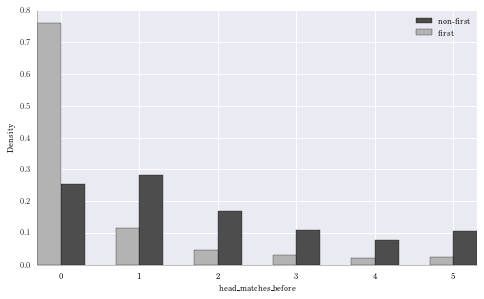

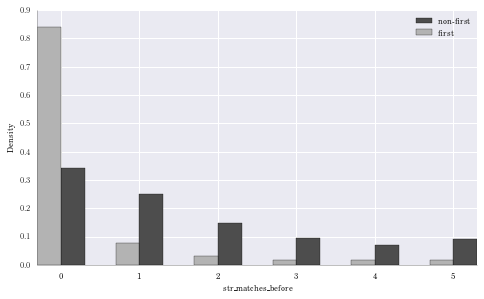

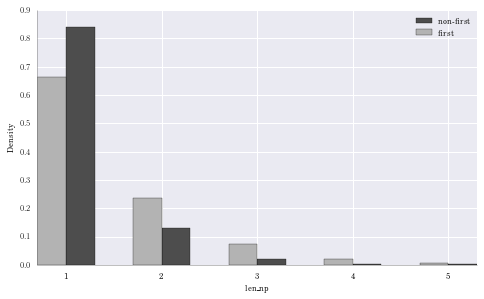

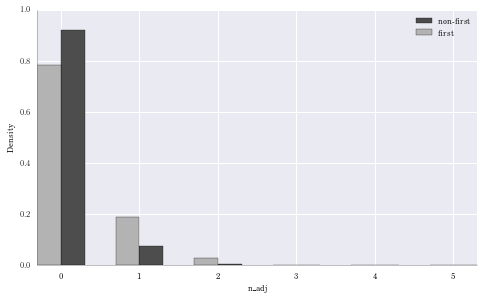

In [35]:
import os

anaphoralib.experiments.utils.latexify(columns=2)
for feat_name in feature_distributions:
    if feat_name == 'class':
        continue
    anaphoralib.experiments.utils.plot_feature_distribution(feature_distributions[feat_name], 
                                                            range(7),
                                                            first_mention_clf.class_names_, 
                                                            x_label=feat_name.replace('_', '\\_'), 
                                                            filename=os.path.join('CICLing-2016', feat_name))

In [36]:
from sklearn.learning_curve import learning_curve
from sklearn.metrics import make_scorer, f1_score
from sklearn.utils import shuffle

In [37]:
first_mention_clf = FirstMentionClassifier()
first_mention_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct', 'lists'))
clf = RandomForestClassifier(n_estimators=500, random_state=random_state)

In [44]:
shuffled_x_data, shuffled_y_data = shuffle(first_mention_clf.x_data, first_mention_clf.y_data, 
                                           random_state=random_state)

train_sizes_abs, train_scores, test_scores = learning_curve(clf, 
                                                            shuffled_x_data,
                                                            shuffled_y_data,
                                                            cv=3,
                                                            scoring=make_scorer(f1_score, pos_label=1))

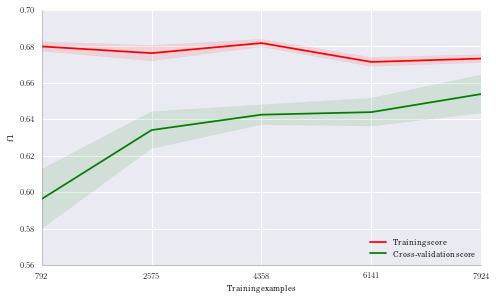

In [45]:
anaphoralib.experiments.utils.latexify(columns=2)
anaphoralib.experiments.utils.plot_learning_curve(train_sizes_abs, 
                                                  train_scores, test_scores, 
                                                  score_name='f1',
                                                  filename=os.path.join('CICLing-2016', 'learning_curve_plot'))